In [1]:
# 01_relation_similarity_analysis_supplement
#
# created by LuYF-Lemon-love <luyanfeng_nlp@qq.com> on April 18, 2023
# updated by LuYF-Lemon-love <luyanfeng_nlp@qq.com> on April 18, 2023
#
# 该脚本展示了如何分析训练的关系嵌入.
#
# 需要的包:
#          numpy
#          csv
#          matplotlib
#          sklearn
#
# 需要的文件:
#          ../01-model/ckpts/TransE_l2_All_DRKG_0/All_DRKG_TransE_l2_relation.npy
#          ../01-model/ckpts/ComplEx_All_DRKG_0/All_DRKG_ComplEx_relation.npy
#          ../01-model/ckpts/RotatE_All_DRKG_0/All_DRKG_RotatE_relation.npy
#          ../../data/drkg/relations.tsv
#
# 源教程链接: https://github.com/gnn4dr/DRKG/blob/master/embedding_analysis/Relation_similarity_analysis.ipynb

# DRKG Relation Embedding Similarity Analysis
 
这个 notebook 展示了如何分析训练的关系嵌入.

在这个例子中, 我们首先加载训练的嵌入向量, 然后将它们映射回原始的关系名, 最后应用下面方法分析它们:

- 投射嵌入进入低维空间并可视化它们的分布.

In [2]:
import numpy as np
import csv
import sklearn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.ticker import PercentFormatter
from matplotlib import colors

In [3]:
!mkdir -p ./result

## Loading Relation ID Mapping

In [4]:
rel2id = {}
id2rel = {}

with open("../../data/drkg/relations.tsv", newline = '', encoding = 'utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter='\t', fieldnames=['id','rel'])
    for row_val in reader:
        id = row_val['id']
        relation = row_val['rel']

        rel2id[relation] = int(id)
        id2rel[int(id)] = relation

print("Number of relations: {}".format(len(rel2id)))

Number of relations: 107


## Treatment relation

In [5]:
treatment_list = [
'DRUGBANK::treats::Compound:Disease',
'GNBR::T::Compound:Disease',
'Hetionet::CtD::Compound:Disease'
]

In [6]:
treatment_list

['DRUGBANK::treats::Compound:Disease',
 'GNBR::T::Compound:Disease',
 'Hetionet::CtD::Compound:Disease']

## Loading Relation Embeddings

In [7]:
TransE_l2_rel_emb = np.load('../01-model/ckpts/TransE_l2_All_DRKG_0/All_DRKG_TransE_l2_relation.npy')
ComplEx_rel_emb = np.load('../01-model/ckpts/ComplEx_All_DRKG_0/All_DRKG_ComplEx_relation.npy')
RotatE_rel_emb = np.load('../01-model/ckpts/RotatE_All_DRKG_0/All_DRKG_RotatE_relation.npy')
print(TransE_l2_rel_emb.shape, ComplEx_rel_emb.shape, RotatE_rel_emb.shape)

(107, 400) (107, 400) (107, 200)


## General Relation Embedding Clustering

这里我们使用 t-SNE 将关系嵌入降维, 然后可视化它们的分布.

In [8]:
# 将关系按照源数据集分类
dataset_id = {}
for rel_name, i in rel2id.items():
    rel_key = rel_name.split('::')[0]
    if dataset_id.get(rel_key, None) is None:
        dataset_id[rel_key] = []
    dataset_id[rel_key].append(i)

In [9]:
# 降维并转置, 降维的结果每次都不同
try:
    X_TransE_l2_embedded = np.load('./result/relation/X_TransE_l2_embedded.npy')
    X_ComplEx_embedded = np.load('./result/relation/X_ComplEx_embedded.npy')
    X_RotatE_embedded = np.load('./result/relation/X_RotatE_embedded.npy')
    print("加载之前保存好的 embedded.")
except Exception as e :
    print("重新计算 embedded.")
    X_TransE_l2_embedded = TSNE(n_components=2).fit_transform(TransE_l2_rel_emb).T
    X_ComplEx_embedded = TSNE(n_components=2).fit_transform(ComplEx_rel_emb).T
    X_RotatE_embedded = TSNE(n_components=2).fit_transform(RotatE_rel_emb).T
    np.save('./result/relation/X_TransE_l2_embedded.npy', X_TransE_l2_embedded)
    np.save('./result/relation/X_ComplEx_embedded.npy', X_ComplEx_embedded)
    np.save('./result/relation/X_RotatE_embedded.npy', X_RotatE_embedded)

加载之前保存好的 embedded.


## Pair-wise Relation Embedding Cosine Similarity

我们使用余弦距离计算成对的嵌入相似度, 然后输出最相似的 10 对.

In [10]:
# 计算余弦相似度
similarity_TransE_l2 = sklearn.metrics.pairwise.cosine_similarity(TransE_l2_rel_emb)
similarity_ComplEx = sklearn.metrics.pairwise.cosine_similarity(ComplEx_rel_emb)
similarity_RotatE = sklearn.metrics.pairwise.cosine_similarity(RotatE_rel_emb)
similaritys = [similarity_TransE_l2, similarity_ComplEx, similarity_RotatE]

然后, 我们绘制了成对相似度得分分布的直方图.

In [11]:
def plot_similarity(similarity):
    # 将相似度矩阵平铺
    similarity = similarity.flatten()
    
    # 清除 self-compare 和 dup-compare
    s = similarity < 0.99
    s = np.unique(similarity[s])
    print(f"s.shape: {s.shape}.")
    print(f"min: {s[0]:.3f}, max: {s[-1]:.3f}.")
    print(f"> 0.90: {len(s[s>0.90])/s.shape[0]*100:.0f}%, >0.50: {len(s[s>0.50])/s.shape[0]*100:.0f}%")
    return s, s.shape[0]

In [12]:
def plot_hist(dist, ax):
    # N is the count in each bin, bins is the lower-limit of the bin
    N, bins, patches = ax.hist(dist)
    
    '''
    # We'll color code by height, but you could use any scalar
    fracs = N / N.max()
    
    # we need to normalize the data to 0..1 for the full range of the colormap
    norm = colors.Normalize(fracs.min(), fracs.max())
    
    # Now, we'll loop through our objects and set the color of each accordingly
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    '''

s.shape: (5669,).
min: -0.774, max: 0.978.
> 0.90: 0%, >0.50: 5%
s.shape: (5670,).
min: -0.208, max: 0.908.
> 0.90: 0%, >0.50: 1%
s.shape: (5671,).
min: -0.241, max: 0.233.
> 0.90: 0%, >0.50: 0%


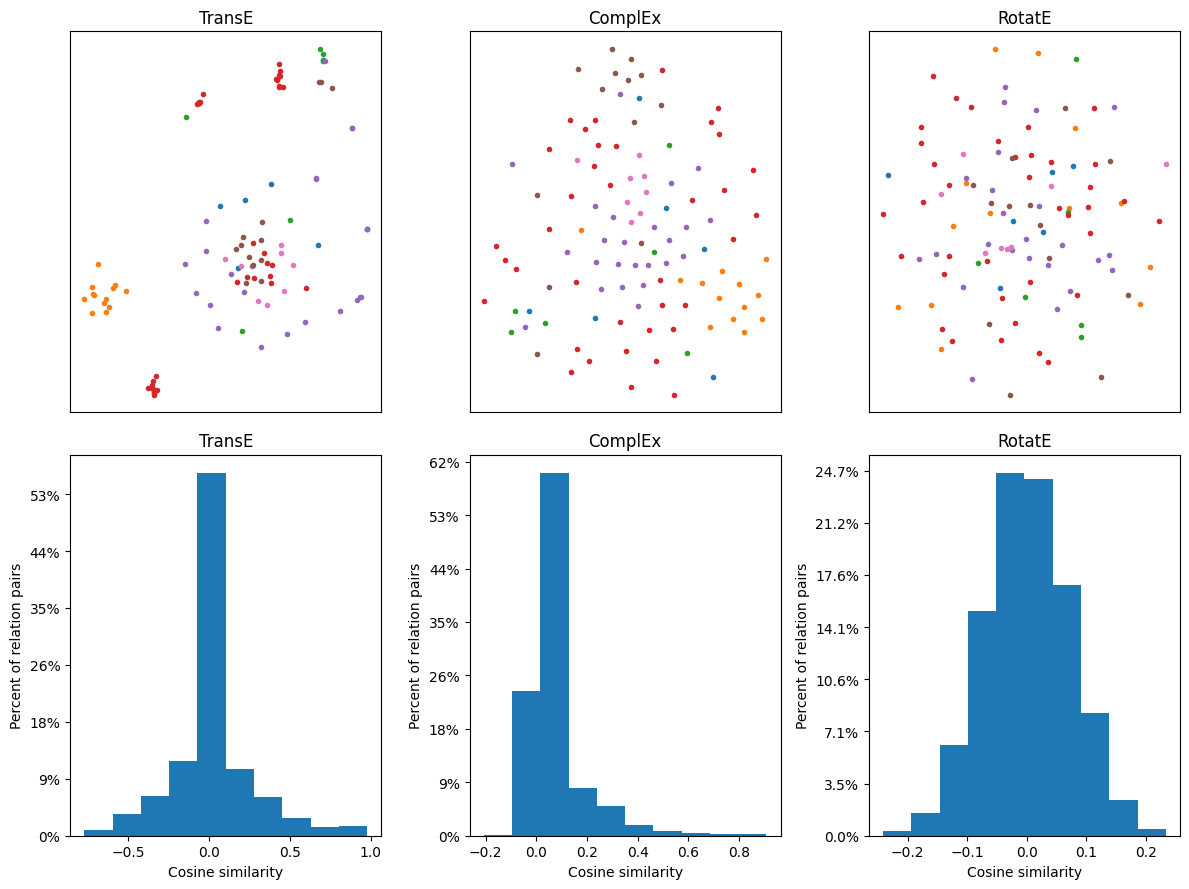

In [13]:
# 绘制，不画 treatments
plt.figure(figsize = (12, 9))
    
# TransE_l2
plt.subplot(231)
plt.title('TransE')
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_TransE_l2_embedded[0][val], X_TransE_l2_embedded[1][val], '.', label=key)

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

# ComplEx
plt.subplot(232)
plt.title('ComplEx')
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_ComplEx_embedded[0][val], X_ComplEx_embedded[1][val], '.', label=key)

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

# RotatE
plt.subplot(233)
plt.title('RotatE')
for key, val in dataset_id.items():
    val = np.asarray(val, dtype=int)
    plt.plot(X_RotatE_embedded[0][val], X_RotatE_embedded[1][val], '.', label=key)

plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

# TransE_l2
ax_b = plt.subplot(234)
plt.title('TransE')

plt.xlabel('Cosine similarity')
plt.ylabel('Percent of relation pairs')
results = plot_similarity(similaritys[0])
plot_hist(results[0], ax_b)
ax_b.yaxis.set_major_formatter(PercentFormatter(results[1]))

# ComplEx
ax_c = plt.subplot(235)
plt.title('ComplEx')

plt.xlabel('Cosine similarity')
plt.ylabel('Percent of relation pairs')
results = plot_similarity(similaritys[1])
plot_hist(results[0], ax_c)
ax_c.yaxis.set_major_formatter(PercentFormatter(results[1]))

# RotatE
ax_d = plt.subplot(236)
plt.title('RotatE')

plt.xlabel('Cosine similarity')
plt.ylabel('Percent of relation pairs')
results = plot_similarity(similaritys[2])
plot_hist(results[0], ax_d)
ax_d.yaxis.set_major_formatter(PercentFormatter(results[1]))

plt.tight_layout()

plt.savefig('./result/relation/relation-flow-chart.svg', bbox_inches='tight', format='svg')
plt.savefig('./result/relation/relation-flow-chart.jpg', bbox_inches='tight', format='jpg')